In [1]:
import random
import networkx as nx
from matplotlib import pyplot as plt
from collections import Counter
import math
from utils.plotTools import plot_qwak
import os
import ast
import numpy as np
import json
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

from scripts import load_list_from_file, write_list_to_file, load_or_generate_data, draw_graph, draw_graph_from_adjacency_matrix,print_matrix
from scripts_theoreticalHittingTime import create_transition_matrix,expected_hitting_time

In [2]:
def estimate_hitting_time( n_values, start_vertex, end_vertex, num_simulations):
    """
    Estimate the hitting time between two vertices in a list of lollipop graphs.

    Parameters:
    m_values (list): The list of m values, each representing the number of vertices in the complete graph part of a lollipop graph.
    n_values (list): The list of n values, each representing the number of vertices in the path part of a lollipop graph.
    start_vertex (int): The starting vertex for the random walk.
    end_vertex (int): The target vertex for the random walk.
    num_simulations (int): The number of simulations to perform.

    Returns:
    hitting_times (list): A list of estimated average hitting times for each lollipop graph.
    """

    hitting_times = []

    for n in  n_values:
        print(f'\nCalculatig hitting time for n={n}')
        total_steps_for_all_simulations = 0

        # Create the lollipop graph
        graph = nx.cycle_graph(n)
        current_node = list(graph.nodes)[start_vertex]
        if end_vertex == 'mid':
            end_node = list(graph.nodes)[n//2]
        else:
            end_node = list(graph.nodes)[end_vertex]
        print(f'Starting node: {current_node} \t Neighbors: {list(nx.neighbors(graph,current_node))}')
        print(f'End node: {end_node} \t Neighbors: {list(nx.neighbors(graph,end_node))}')
        for s in range(num_simulations):
            if s==0 or s==1 or s==10 or s==25 or s==35 or s==49 or s==59 or s==69 or s==79 or s==89 or s==99:
                print(f'----> Sample number:{s}')
                pass
            total_steps_this_simulation = 0
            current_node = list(graph.nodes)[start_vertex]
            # Loop continues until end_vertex is reached
            while current_node != end_node:
                # Choose a neighbor randomly
                neighbors = list(nx.neighbors(graph, current_node))
                if neighbors:
                    current_node = random.choice(neighbors)
                total_steps_this_simulation += 1

            # Accumulate the total steps for this simulation
            total_steps_for_all_simulations += total_steps_this_simulation

        # Average the total steps over the number of simulations
        average_hitting_time = total_steps_for_all_simulations / num_simulations
        hitting_times.append(average_hitting_time)

    return hitting_times

def fit_hitting_time(n,factor,c):
    hitting_times = []
    for i in n:
        hitting_times.append(c*i**factor)
       
    return hitting_times

In [3]:
n_range = list(range(2, 100))

samples = 101

initVertex = 0
targetVertex = 'mid'

factor = 1
c = 1

hitting_times_file = f'Datasets/DynGraphsDTRW/hittingTimeCycle_N{n_range[-1]}_FROM{initVertex}-TO{targetVertex}_S{samples}.txt'

print(f'Looking for: \n-----> {hitting_times_file}')

if os.path.exists(hitting_times_file):
    hitting_times = load_list_from_file(hitting_times_file)
    theoretical_hitting_times = fit_hitting_time(n_range,factor,c)
    print('\nFile exists!')
else:
    print('\nFile Doesnt Exist!')
    hitting_times = estimate_hitting_time(n_range,initVertex,targetVertex,samples)
    theoretical_hitting_times = fit_hitting_time(n_range,factor,c)

    write_list_to_file(hitting_times_file, hitting_times)



Looking for: 
-----> Datasets/DynGraphsDTRW/hittingTimeCycle_N99_FROM0-TOmid_S101.txt

File exists!


#
# Theoretical Hitting Times Krovi

In [4]:
def theoretical_hitting_time(P, init, target):
    """
    Calculate the expected hitting time to state z.

    Parameters:
    P (numpy.ndarray): Transition matrix.
    q (numpy.ndarray): Initial state distribution.
    z (int): Target state.

    Returns:
    float: Expected hitting time to state z from state q.
    """
    
    n = P.shape[0]  # Number of states
    print(n)
    
    if target=='mid':
        target = n//2
        
    order = list(range(n))
    order.remove(target)
    order.append(target)
    
    P = P[np.ix_(order, order)]
        
    P_prime = P[:-1, :-1] 

    init_dist = np.zeros(n-1)
    init_dist[init] = 1
    
    target_dist = np.ones(n-1).T

    I = np.eye(n-1)

    P_prime_inv = np.linalg.inv(I - P_prime)
        
    hitting_time = np.dot(init_dist, np.dot(P_prime_inv, target_dist))

    return hitting_time

def theoretical_hitting_times_for_cycle_graphs(n_range, init, target):
    hitting_times = []
    for n in n_range:
            G = nx.cycle_graph(n)
            P = create_transition_matrix(G)
            hitting_time = theoretical_hitting_time(P, init, target)
            hitting_times.append(hitting_time)
    return hitting_times

n_range = range(2, 100)

init = 0
target = 'mid'

theoretical_hitting_times_file = f'Datasets/DynGraphsDTRW/theoreticalHittingTimeCycle_N{n_range[-1]}_FROM{initVertex}-TO{targetVertex}.txt'

print(f'Looking for: \n-----> {theoretical_hitting_times_file}')

if os.path.exists(theoretical_hitting_times_file):
    theoretical_hitting_times = load_list_from_file(theoretical_hitting_times_file)
    print('\nFile exists!')
else:
    print('\nFile Doesnt Exist!')
    theoretical_hitting_times =  theoretical_hitting_times_for_cycle_graphs(n_range, init, target)
    write_list_to_file(theoretical_hitting_times_file, theoretical_hitting_times)

Looking for: 
-----> Datasets/DynGraphsDTRW/theoreticalHittingTimeCycle_N99_FROM0-TOmid.txt

File exists!


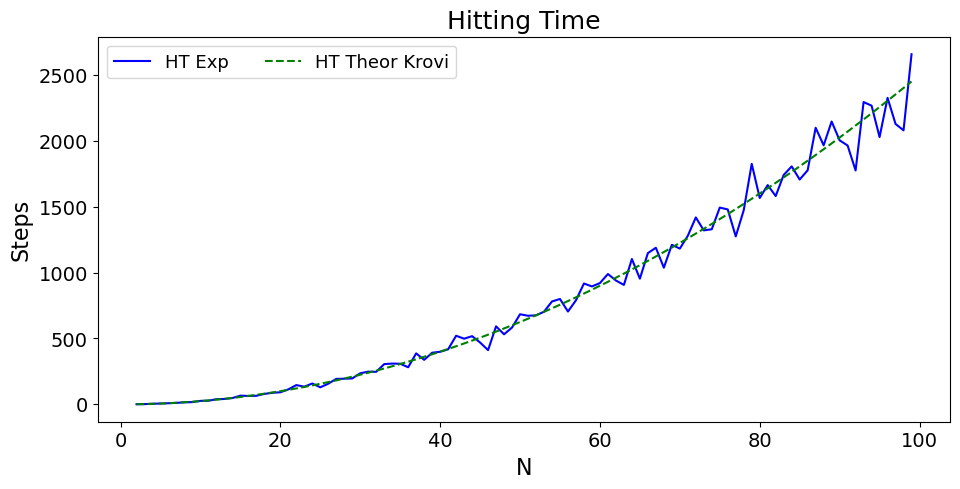

In [5]:
alphaLabelList = [r'HT Exp',f'HT Theor Krovi']


params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'Hitting Time',
    'x_label' : 'N',
    'y_label' : "Steps",
    'legend_labels' : alphaLabelList,
    'legend_loc': "best",
    # 'legend_title' : r'$\alpha$',
    'legend_ncol' : 2,
    'color_list' : ['#0000FF', '#008000', '#525252','red','#eb4034','#8f82f1'],
    'line_style_list' : ['-', '--','-.',':','-','-.'],
    # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
}

y_value_list = [hitting_times,
                theoretical_hitting_times,
               ]

plot_qwak(x_value_matrix = [list(n_range)]*2 , y_value_matrix = y_value_list ,**params)